- By Providence Adu, PhD

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import arcpy
import os
import glob as gb
import shutil
import matplotlib.pyplot as plt

### Set Path 
- Set directory to the folder that has all the datasets

In [2]:
path = "C:\\Users\\padu\\Desktop\\DCP"
os.chdir(path)

- We will be exporting the shapefiles to a geodatabase called DCP
- Set the directory for the DCP geodatabase , call it ProjectGDB
- Set the overwrite output to true because we may rerun the entire script to re-export everything again

In [3]:
ProjectGDB = 'C:\\Users\\padu\\Desktop\\DCP\\DCP.gdb'
arcpy.env.overwriteOutput = True
arcpy.env.workspace = ProjectGDB

### Read Data

- Export all shapefiles to the DCP geodatabase
- Filter for Queens blocks only
- Filter for Community District 402 only 
- Export Output as CSV tables

In [4]:
# Filter for Queens Borough
Queens = arcpy.management.SelectLayerByAttribute("NYC_Census_Blocks_2020", 
                                                 "NEW_SELECTION", "BoroName = 'Queens'", None)


- Export Feature class of Queens Blocks

In [5]:
arcpy.conversion.FeatureClassToFeatureClass(Queens, ProjectGDB, "QueensBG2020", '', '', '')


<Result 'C:\\Users\\padu\\Desktop\\DCP\\DCP.gdb\\QueensBG2020'>

- Filter for Community District 402

In [6]:
# Filter for CD 402

QueensCommunityDistrict402 = arcpy.management.SelectLayerByAttribute("NYC_Community_Districts_2020", 
                                                 "NEW_SELECTION", "BoroCD = 402", None)

QueensCommunityDistrict402

id,value
0,a Layer object
1,1


- Export Community District 402 feature class call it Queens402

In [7]:
# Export CD 402 as CSV
arcpy.conversion.FeatureClassToFeatureClass(QueensCommunityDistrict402, ProjectGDB, "Queens402", '', '', '')


<Result 'C:\\Users\\padu\\Desktop\\DCP\\DCP.gdb\\Queens402'>

- Use select by location to filter for Block in Queens that are within Community District 402
- In all the are **792** block in Community District 402
- The caveat here is that, depending on the spatial relationship you choose (for example, Completely within, or have their center in) the number of blocks can be less or more. 

In [8]:
Queens402Blocks = arcpy.management.SelectLayerByLocation("QueensBG2020", "WITHIN", "Queens402",None, 
                                                       "NEW_SELECTION", "NOT_INVERT")
Queens402Blocks

id,value
0,a Layer object
1,QueensBG2020_Layer2
2,792


- Export Blocks in Community District 402 feature class, call it Queens402Blocks

In [9]:
# Export filter 
arcpy.conversion.FeatureClassToFeatureClass(Queens402Blocks, 
                                            ProjectGDB, "Queens402Blocks", '', '', '')

<Result 'C:\\Users\\padu\\Desktop\\DCP\\DCP.gdb\\Queens402Blocks'>

- Export Queens402Blocks as CSV file

In [10]:
arcpy.conversion.TableToTable(Queens402Blocks, path, 
                              "QueensBlocks402.csv", 
                              '', '', '')


<Result 'C:\\Users\\padu\\Desktop\\DCP\\QueensBlocks4020.csv'>

- Read the Queens Community District 402 csv blocks that was exported in the previous step  using pandas


In [11]:
QueensBG402 = pd.read_csv('QueensBlocks402.csv')

QueensBG402.columns


Index(['OID_', 'CB2020', 'BoroCode', 'BoroName', 'CT2020', 'BCTCB2020',
       'GEOID', 'Shape_Length', 'Shape_Area'],
      dtype='object')

- The exported CSV has columns like OID, shape length, and shape area, we don't want those we use the data frame to get columns we area only interested in

In [12]:
QueensBG402 = pd.DataFrame(QueensBG402[['CB2020', 'BoroCode', 'BoroName', 'CT2020', 'BCTCB2020','GEOID']])

QueensBG402.shape

(792, 6)

#### Read NYC Jobs LEHD Data
- Read CSV data 
- Rename columns using the LEHD Dataset Structure as a guide


In [13]:
NYCJobs = pd.read_csv('ny_wac_S000_JT00_2021.csv')
NYCJobs.head()

,w_geocode,C000,CA01,CA02,CA03,CE01,CE02,CE03,CNS01,CNS02,...,CFA02,CFA03,CFA04,CFA05,CFS01,CFS02,CFS03,CFS04,CFS05,createdate
0,360010001001003,2,0,2,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,20231016
1,360010001001004,51,6,41,4,3,3,45,0,0,...,0,0,0,0,0,0,0,0,0,20231016
2,360010001001005,33,6,16,11,1,4,28,0,0,...,0,0,0,0,0,0,0,0,0,20231016
3,360010001001006,38,7,24,7,6,5,27,0,0,...,0,0,0,0,0,0,0,0,0,20231016
4,360010001001007,127,13,77,37,15,23,89,0,0,...,0,0,0,0,0,0,0,0,0,20231016


- Preview columns
- The data has columns has codes for different variable, for example, C000 corresponds with total number of jobs. 

In [14]:
NYCJobs.columns

Index(['w_geocode', 'C000', 'CA01', 'CA02', 'CA03', 'CE01', 'CE02', 'CE03',
       'CNS01', 'CNS02', 'CNS03', 'CNS04', 'CNS05', 'CNS06', 'CNS07', 'CNS08',
       'CNS09', 'CNS10', 'CNS11', 'CNS12', 'CNS13', 'CNS14', 'CNS15', 'CNS16',
       'CNS17', 'CNS18', 'CNS19', 'CNS20', 'CR01', 'CR02', 'CR03', 'CR04',
       'CR05', 'CR07', 'CT01', 'CT02', 'CD01', 'CD02', 'CD03', 'CD04', 'CS01',
       'CS02', 'CFA01', 'CFA02', 'CFA03', 'CFA04', 'CFA05', 'CFS01', 'CFS02',
       'CFS03', 'CFS04', 'CFS05', 'createdate'],
      dtype='object')

- Using the LEHD Datasets Structure guide, let's rename the columns to make them it more intuitive

In [15]:
NYCJobs.rename(columns = {'C000': 'Total_num','CA01': 'Age_29_or_younger', 'CA02': 'Age_30_to_54',
                          'CA03': 'Age_55_or_older', 'CE01': 'Earnings_1250_or_less',
                          'CE02': 'Earnings_1251_to_3333','CE03': 'Earnings_3333_or_more',
                          'CNS01': 'Agriculture, Forestry, Fishing and Hunting',
                          'CNS02': 'Mining, Quarying, and Oil and Gas Extraction','CNS03': 'Utilities',
                          'CNS04': 'Construction','CNS05': 'Manufacturing','CNS06': 'Wholesale Trade',
                          'CNS07': 'Retail Trade','CNS08': 'Transportation and Warehousing','CNS09': 'Information',
                          'CNS10': 'Finance and Insurance','CNS11': 'Real Estate and Rental Leasing',
                          'CNS12': 'Professional, Scientific, and Technical Services',
                          'CNS13': 'Management of Companies and Enterprises',
                          'CNS14': 'Administrative, Support,  Waste Management and Remidiation Services',
                          'CNS15': 'Educational Services', 'CNS16': 'Health Care and Social Assistance',
                          'CNS17': 'Arts, Entertainment and Recreation','CNS18': 'Accommodation and Food Services',
                          'CNS19': 'Other Services', 'CNS20': 'Public Administration', 'CR01': 'Race_White',
                          'CR02': 'Race_Black_African_American','CR03': 'Race_American_Indian_Alaska_Native',
                          'CR04': 'Race_Asian', 'CR05': 'Race_Native_Hawaiian_Pacific_Islander',
                          'CR07': 'Race_Two_or_More_Races','CT01': 'Ethnicity_Not_Hispanic_Latino',
                          'CT02': 'Ethnicity_Hispanic_Latino', 'CD01': 'Education_Less_than_High_School',
                          'CD02': 'Education_High_School_no_College',
                          'CD03': 'Education_Some_College_Associate_Degree','CD04': 'Education_Bachelor_or_Higher',
                          'CS01': 'Sex_Male','CS02': 'Sex_Female','CFA01': 'Firm_Age_0_to_1_years',
                          'CFA02': 'Firm_Age_2_to_3_years', 'CFA03': 'Firm_Age_4_to_5_years',
                          'CFA04': 'Firm_Age_6_to_10_years','CFA05': 'Firm_Age_11_or_more_years',
                          'CFS01': 'Firm_Size_0_to_19_emp', 'CFS02': 'Firm_Size_20_to_49_emp',
                          'CFS03': 'Firm_Size_50_to_249_emp','CFS04': 'Firm_Size_250_to_499_emp',
                          'CFS05': 'Firm_Size_500_or_more_emp'},inplace = True)

In [16]:
NYCJobs.head()

,w_geocode,Total_num,Age_29_or_younger,Age_30_to_54,Age_55_or_older,Earnings_1250_or_less,Earnings_1251_to_3333,Earnings_3333_or_more,"Agriculture, Forestry, Fishing and Hunting","Mining, Quarying, and Oil and Gas Extraction",...,Firm_Age_2_to_3_years,Firm_Age_4_to_5_years,Firm_Age_6_to_10_years,Firm_Age_11_or_more_years,Firm_Size_0_to_19_emp,Firm_Size_20_to_49_emp,Firm_Size_50_to_249_emp,Firm_Size_250_to_499_emp,Firm_Size_500_or_more_emp,createdate
0,360010001001003,2,0,2,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,20231016
1,360010001001004,51,6,41,4,3,3,45,0,0,...,0,0,0,0,0,0,0,0,0,20231016
2,360010001001005,33,6,16,11,1,4,28,0,0,...,0,0,0,0,0,0,0,0,0,20231016
3,360010001001006,38,7,24,7,6,5,27,0,0,...,0,0,0,0,0,0,0,0,0,20231016
4,360010001001007,127,13,77,37,15,23,89,0,0,...,0,0,0,0,0,0,0,0,0,20231016


- To get the total number of jobs in each block, we have to join blocks to NYC LEHD jobs data
- The blocks have a GEOID column, and the NYE LEHD has a w_geocode ID allowing us to merge the two datasets

In [17]:
LEHD = pd.merge(QueensBG402,NYCJobs,how = 'left' ,left_on='GEOID', right_on= 'w_geocode')
LEHD

,CB2020,BoroCode,BoroName,CT2020,BCTCB2020,GEOID,w_geocode,Total_num,Age_29_or_younger,Age_30_to_54,...,Firm_Age_2_to_3_years,Firm_Age_4_to_5_years,Firm_Age_6_to_10_years,Firm_Age_11_or_more_years,Firm_Size_0_to_19_emp,Firm_Size_20_to_49_emp,Firm_Size_50_to_249_emp,Firm_Size_250_to_499_emp,Firm_Size_500_or_more_emp,createdate
0,1000,4,Queens,101,40001011000,360810001011000,3.608100e+14,227.0,41.0,126.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20231016.0
1,1000,4,Queens,102,40001021000,360810001021000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000,4,Queens,104,40001041000,360810001041000,3.608100e+14,21.0,3.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20231016.0
3,1000,4,Queens,701,40007011000,360810007011000,3.608100e+14,165.0,34.0,97.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20231016.0
4,1000,4,Queens,1901,40019011000,360810019011000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,4006,4,Queens,29100,40291004006,360810291004006,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
788,2002,4,Queens,24500,40245002002,360810245002002,3.608102e+14,3.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20231016.0
789,4002,4,Queens,24500,40245004002,360810245004002,3.608102e+14,4.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20231016.0
790,1005,4,Queens,21900,40219001005,360810219001005,3.608102e+14,63.0,11.0,45.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20231016.0


- Create a list for the NAICS Sector jobs

In [18]:
Sectors = [ 'Agriculture, Forestry, Fishing and Hunting', 'Mining, Quarying, and Oil and Gas Extraction',
           'Utilities', 'Construction', 'Manufacturing', 'Wholesale Trade', 'Retail Trade', 
           'Transportation and Warehousing', 'Information', 'Finance and Insurance', 
           'Real Estate and Rental Leasing', 'Professional, Scientific, and Technical Services',
           'Management of Companies and Enterprises', 
           'Administrative, Support,  Waste Management and Remidiation Services', 
           'Educational Services', 'Health Care and Social Assistance', 
           'Arts, Entertainment and Recreation', 'Accommodation and Food Services', 
           'Other Services', 'Public Administration']

- Create a Dataframe from the NAICS jobs list

In [19]:
NAICSJobs = pd.DataFrame(LEHD[Sectors])
NAICSJobs

,"Agriculture, Forestry, Fishing and Hunting","Mining, Quarying, and Oil and Gas Extraction",Utilities,Construction,Manufacturing,Wholesale Trade,Retail Trade,Transportation and Warehousing,Information,Finance and Insurance,Real Estate and Rental Leasing,"Professional, Scientific, and Technical Services",Management of Companies and Enterprises,"Administrative, Support, Waste Management and Remidiation Services",Educational Services,Health Care and Social Assistance,"Arts, Entertainment and Recreation",Accommodation and Food Services,Other Services,Public Administration
0,0.0,0.0,0.0,1.0,8.0,0.0,16.0,0.0,5.0,4.0,3.0,6.0,0.0,14.0,2.0,33.0,0.0,39.0,96.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,6.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0
3,0.0,0.0,0.0,86.0,5.0,0.0,3.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,4.0,0.0,0.0,40.0,20.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
788,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
789,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
790,0.0,0.0,0.0,4.0,0.0,59.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- Sum all the sub sector jobs in Community District 402
- Create a dataframe from the sum, call the category sum column *2021 Employment*, reset the index so the categories do not become the index of the dataframe
- Rename the old index which are the categories as sector

In [20]:
SectorTotals = pd.DataFrame(NAICSJobs.sum(), columns =['2021 Employment']).reset_index()
SectorTotals.rename(columns = {'index':'Sector'},inplace = True)
SectorTotals

,Sector,2021 Employment
0,"Agriculture, Forestry, Fishing and Hunting",6.0
1,"Mining, Quarying, and Oil and Gas Extraction",0.0
2,Utilities,13.0
3,Construction,13927.0
4,Manufacturing,4582.0
5,Wholesale Trade,5020.0
6,Retail Trade,7295.0
7,Transportation and Warehousing,6678.0
8,Information,1410.0
9,Finance and Insurance,2871.0


- Create a list for the Macro Sectors 

In [21]:
Industrial = ['Agriculture, Forestry, Fishing and Hunting','Mining, Quarying, and Oil and Gas Extraction',
              'Utilities','Wholesale Trade','Transportation and Warehousing','Manufacturing','Construction']


Institutional = ['Educational Services','Health Care and Social Assistance']

LocalServices = ['Accommodation and Food Services','Arts, Entertainment and Recreation',
                 'Retail Trade','Other Services']

Office = ['Administrative, Support,  Waste Management and Remidiation Services',
          'Finance and Insurance','Information', 'Management of Companies and Enterprises',
          'Real Estate and Rental Leasing','Public Administration',
          'Professional, Scientific, and Technical Services']

- Filter the sectors under each macro sector 

In [22]:
IndustrialSector = SectorTotals[SectorTotals['Sector'].isin(Industrial)]
InstitutionalSector = SectorTotals[SectorTotals['Sector'].isin(Institutional)]
LocalServicesSector = SectorTotals[SectorTotals['Sector'].isin(LocalServices)]
OfficeSector = SectorTotals[SectorTotals['Sector'].isin(Office)]

- Sum the totals for all the different sectors under each of the macro sectors
- Get the overall sum for all the sectors (OverallTotal)

In [23]:
IndustrialSectortotal = IndustrialSector['2021 Employment'].sum()
InstitutionalSectortotal = InstitutionalSector['2021 Employment'].sum()
LocalServicesSectortotal = LocalServicesSector['2021 Employment'].sum()
OfficeSectortotal = OfficeSector['2021 Employment'].sum()
OverallTotal = SectorTotals['2021 Employment'].sum()

- Create a Dictionary that maps the totals of the macro sectors and their totals 
- Create dataframe from the dictionary
- Append the dataframe to the orignal dataframe 


In [24]:
Totals = pd.DataFrame({
    
    'Sector' :['Industrial', 'Institutional', 'Local Services', 'Office', 'Total'],
    '2021 Employment': [IndustrialSectortotal, InstitutionalSectortotal,
                        LocalServicesSectortotal,OfficeSectortotal,OverallTotal]
})



SectorTotals = SectorTotals.append(Totals, ignore_index=True)
SectorTotals

,Sector,2021 Employment
0,"Agriculture, Forestry, Fishing and Hunting",6.0
1,"Mining, Quarying, and Oil and Gas Extraction",0.0
2,Utilities,13.0
3,Construction,13927.0
4,Manufacturing,4582.0
5,Wholesale Trade,5020.0
6,Retail Trade,7295.0
7,Transportation and Warehousing,6678.0
8,Information,1410.0
9,Finance and Insurance,2871.0


- Export final data as CSV

In [25]:
SectorTotals.to_csv('NYCLEHDJobsCD402.csv', index= False)

- Create a dictionary for the NAICS two digit codes

In [26]:
NAIC2digits = {
    "11": "Agriculture, Forestry, Fishing and Hunting",
    "21": "Mining, Quarying, and Oil and Gas Extraction",
    "22": "Utilities",
    "23": "Construction",
    "31-33": "Manufacturing",
    "42": "Wholesale Trade",
    "44-45": "Retail Trade",
    "48-49": "Transportation and Warehousing",
    "51": "Information",
    "52": "Finance and Insurance",
    "53": "Real Estate and Rental Leasing",
    "54": "Professional, Scientific, and Technical Services",
    "55": "Management of Companies and Enterprises",
    "56": "Administrative, Support,  Waste Management and Remidiation Services",
    "61": "Educational Services",
    "62": "Health Care and Social Assistance",
    "71": "Arts, Entertainment and Recreation",
    "72": "Accommodation and Food Services",
    "81": "Other Services",
    "92": "Public Administration"
}

- Create a dataframe from the NAICS Codes

In [27]:
NAICS = pd.DataFrame(list(NAIC2digits.items()), columns=['NAIC 2-digit', 'Sector'])
NAICS

,NAIC 2-digit,Sector
0,11,"Agriculture, Forestry, Fishing and Hunting"
1,21,"Mining, Quarying, and Oil and Gas Extraction"
2,22,Utilities
3,23,Construction
4,31-33,Manufacturing
5,42,Wholesale Trade
6,44-45,Retail Trade
7,48-49,Transportation and Warehousing
8,51,Information
9,52,Finance and Insurance


- Merge NAICS 2 digits code to sector jobs summary

In [28]:
LEHDNAICS = pd.merge(SectorTotals,NAICS,how = 'left' ,on='Sector')
LEHDNAICS

,Sector,2021 Employment,NAIC 2-digit
0,"Agriculture, Forestry, Fishing and Hunting",6.0,11
1,"Mining, Quarying, and Oil and Gas Extraction",0.0,21
2,Utilities,13.0,22
3,Construction,13927.0,23
4,Manufacturing,4582.0,31-33
5,Wholesale Trade,5020.0,42
6,Retail Trade,7295.0,44-45
7,Transportation and Warehousing,6678.0,48-49
8,Information,1410.0,51
9,Finance and Insurance,2871.0,52


In [29]:
LEHDNAICS.to_csv('LEHDNAICSJobsCD402.csv', index = False)

- *End of Analysis* Now Charts and Insights

- Create a pie chart that compares macros sectors

In [30]:
sectors = ['Industrial', 'Institutional', 'Local Services', 'Office']
Total = [30226, 10890, 13026, 37612]
colors = ['gold', 'lightskyblue', 'lightcoral', 'lightgreen']

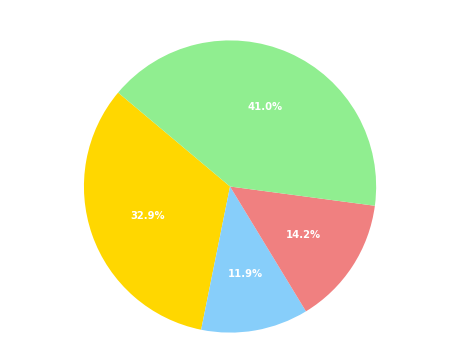

In [31]:
# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(Total, labels=sectors, colors=colors, autopct='%1.1f%%',startangle=140,textprops={'color': 'white', 'fontweight': 'bold'})
plt.title('Employment Distribution in Different Sectors', color = 'white')
plt.axis('equal')  

# Display the plot
plt.show()

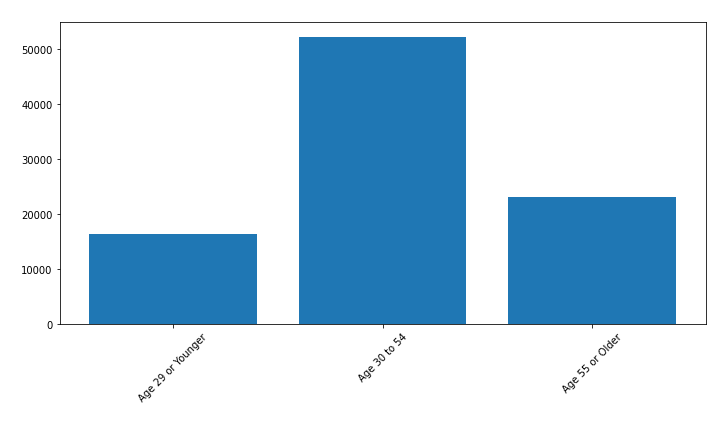

In [32]:
# Data
categories = ['Age 29 or Younger', 'Age 30 to 54', 'Age 55 or Older']
employment = [16374, 52283, 23097]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(categories, employment)

plt.xlabel('Age Groups',color='white')
plt.ylabel('Number of Employees',color='white')
plt.title('Age Distribution of Employment in Queens (2021)',color='white')


plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()